# Prepare Circuits

In [75]:
# Importing standard Qiskit modules
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter, Instruction

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
from qiskit.opflow import Zero, One, I, X, Y, Z

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy

import seaborn as sns

In [2]:
def gen_trott_gate():
    t = Parameter('t') # parameterize variable t
    
    # XX(t)
    XX_qr = QuantumRegister(2)
    XX_qc = QuantumCircuit(XX_qr, name='XX')

    XX_qc.ry(np.pi/2,[0,1])
    XX_qc.cnot(0,1)
    XX_qc.rz(2 * t, 1)
    XX_qc.cnot(0,1)
    XX_qc.ry(-np.pi/2,[0,1])

    # Convert custom quantum circuit into a gate
    XX = XX_qc.to_instruction()
    
    # YY(t)
    YY_qr = QuantumRegister(2)
    YY_qc = QuantumCircuit(YY_qr, name='YY')

    YY_qc.rx(np.pi/2,[0,1])
    YY_qc.cnot(0,1)
    YY_qc.rz(2 * t, 1)
    YY_qc.cnot(0,1)
    YY_qc.rx(-np.pi/2,[0,1])

    # Convert custom quantum circuit into a gate
    YY = YY_qc.to_instruction()

        
    # ZZ(t)
    ZZ_qr = QuantumRegister(2)
    ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ')

    ZZ_qc.cnot(0,1)
    ZZ_qc.rz(2 * t, 1)
    ZZ_qc.cnot(0,1)

    # Convert custom quantum circuit into a gate
    ZZ = ZZ_qc.to_instruction()
    
    num_qubits = 3

    Trott_qr = QuantumRegister(num_qubits)
    Trott_qc = QuantumCircuit(Trott_qr, name='Trot')

    for i in range(0, num_qubits - 1):
        Trott_qc.append(ZZ, [Trott_qr[i], Trott_qr[i+1]])
        Trott_qc.append(YY, [Trott_qr[i], Trott_qr[i+1]])
        Trott_qc.append(XX, [Trott_qr[i], Trott_qr[i+1]])

    # Convert custom quantum circuit into a gate
    Trott_gate = Trott_qc.to_instruction()
    return Trott_gate

In [3]:
def gen_qcs(trott_gate: Instruction, trotter_steps: int):
    """
    Args:
        n (int): number of trotter steps
    """
    
    t = trott_gate.params[0] # assuming only t param
    
    target_time = np.pi
    
    qr = QuantumRegister(7)
    qc = QuantumCircuit(qr)
    
    qc.x([3,5]) # prepare init state |q5q3q1> = |110>
    
    for _ in range(trotter_steps):
        qc.append(trott_gate, [qr[1], qr[3], qr[5]])
    
    qc = qc.bind_parameters({t: target_time/trotter_steps})
    
    st_qcs = state_tomography_circuits(qc, [qr[1], qr[3], qr[5]])
    
    return st_qcs
    
    

In [4]:
trott_steps_range = np.arange(4,15,1)
trott_gate = gen_trott_gate() # using the basic trott method (this can be changed)

qcs = {}
for trott_steps_val in trott_steps_range:
    qcs[trott_steps_val] = gen_qcs(trott_gate, trott_steps_val)

In [5]:
qcs[10][-2].draw() # e.g. 10 trott steps, example tomo circuit

»
q87409_0: ─────────────────────────────────────────────────────────────────»
               ┌─────────────┐┌─────────────┐┌─────────────┐┌─────────────┐»
q87409_1: ─────┤0            ├┤0            ├┤0            ├┤0            ├»
               │             ││             ││             ││             │»
q87409_2: ─────┤             ├┤             ├┤             ├┤             ├»
          ┌───┐│             ││             ││             ││             │»
q87409_3: ┤ X ├┤1 Trot(π/10) ├┤1 Trot(π/10) ├┤1 Trot(π/10) ├┤1 Trot(π/10) ├»
          └───┘│             ││             ││             ││             │»
q87409_4: ─────┤             ├┤             ├┤             ├┤             ├»
          ┌───┐│             ││             ││             ││             │»
q87409_5: ┤ X ├┤2            ├┤2            ├┤2            ├┤2            ├»
          └───┘└─────────────┘└─────────────┘└─────────────┘└─────────────┘»
q87409_6: ─────────────────────────────────────────────────────────────────»
                                                                           »
   c17: 3/═════════════════════════════════════════════════════════════════»
                                                                           »
«                                                                      »
«q87409_0: ────────────────────────────────────────────────────────────»
«          ┌─────────────┐┌─────────────┐┌─────────────┐┌─────────────┐»
«q87409_1: ┤0            ├┤0            ├┤0            ├┤0            ├»
«          │             ││             ││             ││             │»
«q87409_2: ┤             ├┤             ├┤             ├┤             ├»
«          │             ││             ││             ││             │»
«q87409_3: ┤1 Trot(π/10) ├┤1 Trot(π/10) ├┤1 Trot(π/10) ├┤1 Trot(π/10) ├»
«          │             ││             ││             ││             │»
«q87409_4: ┤             ├┤             ├┤             ├┤             ├»
«          │             ││             ││             ││             │»
«q87409_5: ┤2            ├┤2            ├┤2            ├┤2            ├»
«          └─────────────┘└─────────────┘└─────────────┘└─────────────┘»
«q87409_6: ────────────────────────────────────────────────────────────»
«                                                                      »
«   c17: 3/════════════════════════════════════════════════════════════»
«                                                                      »
«                                         ░                      
«q87409_0: ───────────────────────────────░──────────────────────
«          ┌─────────────┐┌─────────────┐ ░ ┌─┐                  
«q87409_1: ┤0            ├┤0            ├─░─┤M├──────────────────
«          │             ││             │ ░ └╥┘                  
«q87409_2: ┤             ├┤             ├─░──╫───────────────────
«          │             ││             │ ░  ║ ┌─┐               
«q87409_3: ┤1 Trot(π/10) ├┤1 Trot(π/10) ├─░──╫─┤M├───────────────
«          │             ││             │ ░  ║ └╥┘               
«q87409_4: ┤             ├┤             ├─░──╫──╫────────────────
«          │             ││             │ ░  ║  ║ ┌─────┐┌───┐┌─┐
«q87409_5: ┤2            ├┤2            ├─░──╫──╫─┤ Sdg ├┤ H ├┤M├
«          └─────────────┘└─────────────┘ ░  ║  ║ └─────┘└───┘└╥┘
«q87409_6: ───────────────────────────────░──╫──╫──────────────╫─
«                                         ░  ║  ║              ║ 
«   c17: 3/══════════════════════════════════╩══╩══════════════╩═
«                                            0  1              2

# Prepare Target State

In [110]:
import qutip as qt
g = qt.basis(2,0)
e = qt.basis(2,1)

# fidelity: the reconstructed state has the (flipped) ordering |q5q3q1> 
target_state_qt = qt.tensor(e,e,g)
target_state_qt = qt.ket2dm(target_state_qt)
target_state = target_state_qt.full()


# parity: "XYZ" corresponds to X measurement on q1, Y measurement on q3, and Z measurement on q5
target_state_parity_qt = qt.ket2dm( qt.tensor(g,e,e))
target_state_parity = target_state_parity_qt.full()

In [111]:
pauli = {"X":qt.sigmax(),"Y":qt.sigmay(),"Z":qt.sigmaz(),"I":qt.identity(2)}
target_parity = {}
for k1, p1 in pauli.items():
    for k2, p2 in pauli.items():
        for k3, p3 in pauli.items():
            pauli_string = k1+k2+k3
            if pauli_string == "III":
                continue
            op = qt.tensor(p1,p2,p3)
            meas = (target_state_parity_qt*op).tr()
            target_parity[pauli_string] = meas

In [124]:
target_parity

{'XXX': 0.0,
 'XXY': 0.0,
 'XXZ': 0.0,
 'XXI': 0.0,
 'XYX': 0.0,
 'XYY': 0.0,
 'XYZ': 0.0,
 'XYI': 0.0,
 'XZX': 0.0,
 'XZY': 0.0,
 'XZZ': 0.0,
 'XZI': 0.0,
 'XIX': 0.0,
 'XIY': 0.0,
 'XIZ': 0.0,
 'XII': 0.0,
 'YXX': 0.0,
 'YXY': 0.0,
 'YXZ': 0.0,
 'YXI': 0.0,
 'YYX': 0.0,
 'YYY': 0.0,
 'YYZ': 0.0,
 'YYI': 0.0,
 'YZX': 0.0,
 'YZY': 0.0,
 'YZZ': 0.0,
 'YZI': 0.0,
 'YIX': 0.0,
 'YIY': 0.0,
 'YIZ': 0.0,
 'YII': 0.0,
 'ZXX': 0.0,
 'ZXY': 0.0,
 'ZXZ': 0.0,
 'ZXI': 0.0,
 'ZYX': 0.0,
 'ZYY': 0.0,
 'ZYZ': 0.0,
 'ZYI': 0.0,
 'ZZX': 0.0,
 'ZZY': 0.0,
 'ZZZ': 1.0,
 'ZZI': -1.0,
 'ZIX': 0.0,
 'ZIY': 0.0,
 'ZIZ': -1.0,
 'ZII': 1.0,
 'IXX': 0.0,
 'IXY': 0.0,
 'IXZ': 0.0,
 'IXI': 0.0,
 'IYX': 0.0,
 'IYY': 0.0,
 'IYZ': 0.0,
 'IYI': 0.0,
 'IZX': 0.0,
 'IZY': 0.0,
 'IZZ': 1.0,
 'IZI': -1.0,
 'IIX': 0.0,
 'IIY': 0.0,
 'IIZ': -1.0}

# Results

In [112]:
# load IBMQ Account data

# IBMQ.save_account(TOKEN)  # replace TOKEN with your API token string (https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-04-12 21:10:29,011: Credentials are already in use. The existing account in the session will be replaced.


In [113]:
# Get backend for experiment
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
jakarta = provider.get_backend('ibmq_jakarta')
# properties = jakarta.properties()

# Simulated backend based on ibmq_jakarta's device noise profile
sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))

# Noiseless simulated backend
sim = QasmSimulator()

In [114]:
# Compute the state tomography based on the st_qcs quantum circuits and the results from those ciricuits
def state_tomo(result, st_qcs):
    # The expected final state; necessary to determine state tomography fidelity
    # Fit state tomography results
    tomo_fitter = StateTomographyFitter(result, st_qcs)
    rho_fit = tomo_fitter.fit(method='lstsq')
    # Compute fidelity
    return rho_fit
    # fid = state_fidelity(rho_fit, target_state)
    # return fid

In [115]:
def gen_result_single(st_qcs, backend = sim):
    shots = 8192
    reps = 8 #TODO: change back to 8

    # create jobs
    jobs = []
    for _ in range(reps):
        # execute
        job = execute(st_qcs, backend, shots=shots)
        print('Job ID', job.job_id())
        jobs.append(job)
        
    # monitor jobs
    for job in jobs:
        job_monitor(job)
        try:
            if job.error_message() is not None:
                print(job.error_message())
        except:
            pass
    
    # calculate fids
    rhos = []
    raw_results = []
    for job in jobs:
        raw_results.append(job.result())
        rho = state_tomo(raw_results[-1], st_qcs)
        rhos.append(rho)
    
    return rhos, raw_results

def gen_results(qcs, backend = sim):
    results = {"properties": {"backend": backend}, "data":{}}
    # test = 2
    for num_trott_steps, st_qcs in tqdm(qcs.items()):
        print("="*20)
        print(f"Running with trott_steps = {num_trott_steps}")
        
        # if test <= 0:
        #     continue
        # test -= 1
        
        results["data"][num_trott_steps] = {}
        results["data"][num_trott_steps]["rhos"], results["data"][num_trott_steps]["raw_data"] = gen_result_single(st_qcs)
    return results

In [116]:
ACTIVE_LIST = [(1,1,1), (1,1,0), (1,0,1), (0,1,1), (1,0,0), (0,1,0), (0,0,1)] # [ZXY, ZXI, ZIY, IXY, ZII, IXI, IIY]

def extract_key(key):
    # e.g. "('Z', 'Z', 'X')" -> ZZX
    return key[2] + key[7] + key[12]

def add_dicts(a,b):
    c = {}
    keys = set(list(a.keys()) + list(b.keys())) # union of keys
    for key in keys:
        c[key] = a.get(key,0) + b.get(key, 0)
    return c

def calc_parity(pauli_string, readout_string, active_spots):
    """
    Args:
        b (str): e.g. '0x6'
        active_spots (List[int]): e.g. (1, 1, 0)
    """
    n = len(pauli_string)
    
    adjusted_pauli_string = ""
    for i in range(n):
        letter = pauli_string[i]
        adjusted_pauli_string += letter if active_spots[i] else "I"
        
    
    b = list(format(int(readout_string[2:]), '#05b')[2:]) # e.g. "0x6" -> ["1", "1", "0"]
    b = b[::-1] # ["1", "1", "0"] -> ["0", "1", "1"]
    v = np.array([1-int(val)*2 for val in b]) #  ["0", "1", "1"] ->  [1, -1, -1]
    active = v*np.array(active_spots) # [1, -1, -1] * [1, 1, 0] -> [1, -1, 0]
    p = np.prod(active[active!=0]) # [1,-1] -> (1)*(-1) = -1
    y = int((1-p)/2) #map: 1,-1 -> 0,1
    return adjusted_pauli_string, y

def run_analysis(results):
    results = copy.deepcopy(results)
    
    # data map
    num_qubits = 3
    parsed_data = {} # key: e.g. "XYZ", "XYI", .. | val: for each parity measurement (e.g. <XYI>) we store [counts of 1, counts of -1], e.g. [12345, 950] 
    for num_trott_steps, result in results["data"].items():
        # data_map = {}
        reps = len(result["raw_data"])
        for i in range(3**num_qubits):  # loop over pauli strings (i.e. different tomography circuits)
            counts = {} # for each pauli string, we store total counts added together from each rep, e.g. {'0x6': 4014, '0x2': 4178}
            pauli_string = extract_key(result["raw_data"][0].results[i].header.name)
            for r in range(reps): # loop over reps
                counts = add_dicts(counts, result["raw_data"][r].results[i].data.counts) # adding counts together
            # data_map[pauli_string] = counts
            
            for active_spots in ACTIVE_LIST: # Loops through all possible parity measurements, e.g. [ZXY, ZXI, ZIY, IXY, ZII, IXI, IIY]
                for readout_string, count in counts.items(): # loops through all readout values, e.g. '0x6', '0x2'
                    adjusted_pauli_string, parity_meas = calc_parity(pauli_string, readout_string, active_spots) # ("ZXY", "0x6", (1,1,0)) -> "ZXI", 1 corresponds to <ZXI> = -1 measurement
                    # if adjusted_pauli_string == "IIZ":
                    #     print(pauli_string, readout_string, active_spots, adjusted_pauli_string, parity_meas, count)
                    if adjusted_pauli_string not in parsed_data:
                        parsed_data[adjusted_pauli_string] = [0,0] # [counts of 1, counts of -1]
                    parsed_data[adjusted_pauli_string][parity_meas] += count

        # result["data_map"] = data_map
        result["parsed_data"] = parsed_data
        
        parity = {} # key: e.g. "XYZ", "XYI", .. | val: for each parity measurement we store the expectation value (e.g. <XYI>)
        for parity_string, count in parsed_data.items():
            norm = np.sum(count)
            parity[parity_string] = (1)*count[0]/norm + (-1)*count[1]/norm # (1) * (counts of 1) + (-1)*(counts of -1) = <ZXY>
        
        result["parity"] = parity
        
    
    for num_trott_steps, result in results["data"].items():
        # calculate fids for each rep
        fids = []
        for rho in result["rhos"]:
            fids.append(state_fidelity(rho, target_state))
        fids = np.array(fids)
        result["infids"] = 1 - fids
        
        # calculate fid for avg rho
        result["avg_rho"] = np.mean(result["rhos"], axis=0)
        result["avg_infid"] =  1 - state_fidelity(result["avg_rho"], target_state)
        
        # calculate distance from |110><110| matrix element
        result["avg_element_dist"] = np.abs(target_state  - result["avg_rho"])
        
        result["avg_l1_dist"] = np.linalg.norm(target_state  - result["avg_rho"], ord=1)

    return results

In [117]:
def plot_metric(results, metric_func=None, plot_label="Infidelity", plot_log=True, axs=None, legend_label=None):
    metric_func = metric_func if metric_func is not None else lambda res: res["avg_infid"]
    steps = []
    metric = []
    for num_trott_steps, result in results["data"].items():
        steps.append(num_trott_steps)
        metric.append(metric_func(result))
    
    steps = np.array(steps)
    metric = np.array(metric)
    
    if axs is None:
        fig, axs = plt.subplots(2 if plot_log else 1,2, figsize=(8,6 if plot_log else 3), dpi=200, squeeze=False)
    
    ax = axs[0][0]
    ax.plot(1/steps, metric, label=legend_label)
    ax.set_xlabel("1/(# of Trotterization Steps)")
    ax.set_ylabel(plot_label)
    if legend_label is not None:
        ax.legend(fontsize=6)
    
    ax = axs[0][1]
    ax.plot(steps, metric, label=legend_label)
    ax.set_xlabel("(# of Trotterization Steps)")
    ax.set_ylabel(plot_label)
    if legend_label is not None:
        ax.legend(fontsize=6)
    
    if plot_log:
        ax = axs[1][0]
        ax.plot(1/steps, np.log(metric), label=legend_label)
        ax.set_xlabel("1/(# of Trotterization Steps)")
        ax.set_ylabel(f"log({plot_label})")
        if legend_label is not None:
            ax.legend(fontsize=6)

        ax = axs[1][1]
        ax.plot(steps, np.log(metric), label=legend_label)
        ax.set_xlabel("(# of Trotterization Steps)")
        ax.set_ylabel(f"log({plot_label})")
        if legend_label is not None:
            ax.legend(fontsize=6)
    
    fig = plt.gcf()
    fig.suptitle(f"{plot_label} vs. Trotterization Step #")
    
    fig.tight_layout()
    
    
    return axs

def plot_fidelities(results):
    return plot_metric(results, metric_func= lambda res: res["avg_infid"], plot_label="Infidelity")

def plot_element_dist(results, row=6, col=6):
    return plot_metric(results, metric_func= lambda res: res["avg_element_dist"][row][col], plot_label=f"Element Dist. ({row}, {col})")

def plot_l1_dist(results):
    return plot_metric(results, metric_func= lambda res: res["avg_l1_dist"], plot_label=f"L1 Dist.")

def plot_parity(results):
    parity_strings = list(list(results["data"].values())[0]["parity"].keys())
    
    axs = None
    for parity_string in parity_strings[1:]:
        axs = plot_metric(results, metric_func= lambda res: res["parity"][parity_string], plot_label=f"<Pauli String>", plot_log=False, axs=axs) #, legend_label=f"<{parity_string}>")
    
    return axs

def plot_parity_dist(results):
    parity_strings = list(list(results["data"].values())[0]["parity"].keys())
    axs = None
    for parity_string in parity_strings[1:]:
        axs = plot_metric(results, metric_func= lambda res: np.abs(target_parity[parity_string] - res["parity"][parity_string]), plot_label=f"|<Exp PStr> - <Meas PStr>|", plot_log=False, axs=axs) #, legend_label=f"<{parity_string}>")
    
    return axs

## Noiseless Sims

#### Capture Data

In [13]:
results = gen_results(qcs, backend=sim)

  0%|                                                                                                                 | 0/11 [00:00<?, ?it/s]

Running with trott_steps = 4
Job ID bb1619e6-f8cc-47d9-a218-38b9f7c56388
Job ID 638ae2ef-d0ed-4c10-ae1f-2d68721e9a9f
Job ID bfb0a2ed-73b3-4c74-a075-50f13230e55d
Job ID 141416d0-3588-4f0a-ac1a-38097bd04ba8
Job ID 521fdefd-8a7e-4e39-a335-bd97347fbac7
Job ID 53fe4dae-afd4-42a1-b293-d3e6d7032a6d
Job ID 835d92bf-f2f7-4df4-9fc2-fecda84c9967
Job ID fb96df13-5491-45b4-bc14-31ecb7255274
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


  9%|█████████▌                                                                                               | 1/11 [00:49<08:16, 49.65s/it]

Running with trott_steps = 5
Job ID 57328f39-2382-4b5d-a146-fd44e9172cfc
Job ID 7b48176d-4dce-4765-8fdc-415b8a911c5b
Job ID 8a80afd9-9741-464c-9dc4-61769ba9f60a
Job ID 32d48e3c-c101-42e4-93a2-b12586341760
Job ID 36593285-57f3-4366-b001-dc61bda0bce3
Job ID 5ad636e6-9e2a-44ec-9f10-a1997cbf2cb4
Job ID a6112a67-2cd9-4524-b15c-0781c81e6f56
Job ID f289c40a-99c6-41a1-a96f-b3d5c445633e
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 18%|███████████████████                                                                                      | 2/11 [01:53<08:39, 57.78s/it]

Running with trott_steps = 6
Job ID fa0a4df0-133b-4df2-9b8e-3cb6cad64d7f
Job ID fd1c9647-a10f-4372-94ee-47718e3ae775
Job ID d2c4739c-0006-4268-a828-619b28033f96
Job ID 16d621fc-6416-48b1-9235-3206092264c0
Job ID fb67bc37-cd03-4d47-9c6b-a6788531069d
Job ID 0d8abc3c-499d-40bc-9613-abb082195241
Job ID 7cb68991-3574-48ed-808d-f8115f097152
Job ID bbf2d96e-c683-48c6-a908-4448b7877cc3

 27%|████████████████████████████▋                                                                            | 3/11 [02:59<08:15, 61.88s/it]


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Running with trott_steps = 7
Job ID f06f6678-b2c2-44d8-a6d6-42b83e319fe2
Job ID e3f16516-fc59-4893-b36d-e0f51dd82dd2
Job ID 2c071c3f-68d1-46db-bf61-7e484c5d0733
Job ID 2543df60-b4c6-4517-b02f-ed145a44f0eb
Job ID c65cdf12-fb9f-48d9-88b2-65bd8020652f
Job ID 33368bb0-867a-4298-ab9a-b7bca975a3ff
Job ID 8f56adfd-23f7-40c7-8403-ed107d5cb79e
Job ID b769b593-3809-41da-807f-4ce9e2d4a831
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 36%|██████████████████████████████████████▏                                                                  | 4/11 [04:16<07:52, 67.51s/it]

Running with trott_steps = 8
Job ID c21477e9-3449-45b8-b550-6af669456acb
Job ID 578168c5-e0b1-49cf-b573-fbde23a69b2c
Job ID d8c341d9-ecfd-4286-84ca-bb74659cf7cb
Job ID 1e1e29ef-4ed4-45b8-b793-ed8815bc29aa
Job ID 8e4f11a2-89ac-404b-99e6-e05b94e76c9e
Job ID 4e429699-9450-47d1-baeb-ca8fc357170c
Job ID b4e31367-7d9a-4222-bfba-f058bdb5de76
Job ID 32455479-3999-48aa-850e-0754f51ff900
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 45%|███████████████████████████████████████████████▋                                                         | 5/11 [05:43<07:28, 74.70s/it]

Running with trott_steps = 9
Job ID f51ecc72-a20e-4d9e-a0c7-0a49febb3fbb
Job ID 4e4a4ebd-311c-434c-8adf-9202c93a6087
Job ID 8d591d3c-dd83-4148-94fc-f0ebb2e21126
Job ID 81dcd7be-4c93-4d23-8114-1ca2393b1fb1
Job ID 746775e5-e104-412c-bada-ea3f00fc8b25
Job ID e2d54f97-dfbe-4253-be63-91c314f8bbd2
Job ID f2abbf1a-9323-4c20-b78a-9d5cf1de70cb
Job ID 0ebba993-b4a6-402c-a3bd-08753bf012d2
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 55%|█████████████████████████████████████████████████████████▎                                               | 6/11 [07:21<06:53, 82.78s/it]

Running with trott_steps = 10
Job ID 541658dc-7c16-4784-abac-87420e7e0e98
Job ID e97c034b-89c0-4168-9484-106d0fafb10b
Job ID 9d4b611b-89ad-4dce-86d0-4e157a55fb41
Job ID 4316bf9c-a428-4776-b62a-f357273174c5
Job ID cb6914c8-c985-4591-aa12-2b259207390a
Job ID e4d002d3-a056-43d1-a7a2-23625d524740
Job ID 641ad4ba-9603-4913-9e82-04410b6f63d4
Job ID c0cb4d12-3c54-424b-a5c7-bc8621b1042e
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 64%|██████████████████████████████████████████████████████████████████▊                                      | 7/11 [09:09<06:03, 90.94s/it]

Running with trott_steps = 11
Job ID 473945ea-b196-420c-ba11-8c3aa8d12397
Job ID fb226e25-bb19-4414-b450-fd1d49b25add
Job ID b9906a63-3a17-4e96-90db-8060d8f21254
Job ID 3438b2a0-e36a-4e20-adb1-81ae832da26b
Job ID 03e18546-d21d-4efb-8ddf-07d17e19e1f0
Job ID d686fa1d-20dd-475f-9a02-54c64f8b5105
Job ID c35787d0-f3fe-409f-a9b8-d4847d466e94
Job ID 91b7558d-f428-4a8e-a922-c1b4095e654b
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 73%|███████████████████████████████████████████████████████████████████████████▋                            | 8/11 [11:12<05:03, 101.20s/it]

Running with trott_steps = 12
Job ID 1dba023d-cce6-46ff-9d50-471282d1ae91
Job ID 57bd9dbd-cd24-4098-b7c2-3f5966655676
Job ID b71e2dc6-6a98-4093-ab01-7d729b7b5548
Job ID 122125d5-c384-4837-af52-4599eec81b46
Job ID 9c86132f-7899-4aae-adba-7130dbd3ad8e
Job ID 873447c1-ab56-43a5-b349-c12e5ac81033
Job ID 5512c060-00f5-46bb-ae45-da2fd45d27fe
Job ID 32b2de38-0f0b-4114-a093-0e9588c85ed7
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 82%|█████████████████████████████████████████████████████████████████████████████████████                   | 9/11 [13:34<03:47, 113.83s/it]

Running with trott_steps = 13
Job ID c31996ff-0ca2-455e-aaeb-ac8f9bb13073
Job ID d641db6b-6568-49d3-b2bb-0849c5d6c88f
Job ID c8efc188-8f44-40aa-98e6-ffc06aef524b
Job ID 9b2430e7-7385-4a1b-8d6e-3d88a36a93b4
Job ID 1593f863-db13-437b-8067-1a1a58bfa219
Job ID 6e0b7c3a-d367-4287-8021-a292cae1f18c
Job ID 9a4c8003-7ecb-4f93-9f36-8ab0de075a90
Job ID 4dadef26-3279-46cd-9008-95ac736b9463
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


 91%|█████████████████████████████████████████████████████████████████████████████████████████████▋         | 10/11 [15:54<02:02, 122.01s/it]

Running with trott_steps = 14
Job ID 8c71124e-04e1-4a0c-94f8-c35b13f5b5a9
Job ID 72b1e631-8d8b-421c-b70a-697df167b5de
Job ID a8f19981-3f78-4809-8d15-524413ffe3e0
Job ID fe67be3d-bf07-43dc-9347-91d03b6a4d87
Job ID bb469a2c-069c-46ab-bc33-a9c258eb47d4
Job ID 7bc23f86-ba0c-417d-9998-19b219c910c5
Job ID 47e2647b-2df6-49ba-9e0f-4638a31b23dd
Job ID e14c20fa-8268-43f0-9028-bfc1dfc9aad8
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [18:22<00:00, 100.26s/it]


#### Run Analysis

In [118]:
res_analysis = run_analysis(results) 

In [119]:
ps = ["ZZZ", "ZZI", "ZIZ", "IZZ", "ZII", "IZI", "IIZ"]
n = 19
for p in ps:
    print(p, target_parity[p], res_analysis["data"][n]["parity"][p], res_analysis["data"][n]["parsed_data"][p])

ZZZ 1.0 1.0 [1048576, 0]
ZZI -1.0 -0.6869519551595051 [492382, 2653346]
ZIZ -1.0 -0.9589805603027344 [64518, 3081210]
IZZ 1.0 0.6455402374267578 [2588211, 557517]
ZII 1.0 0.6457691192626953 [7765713, 1671471]
IZI -1.0 -0.959006839328342 [193430, 9243754]
IIZ -1.0 -0.686459223429362 [1479471, 7957713]


In [120]:
res_analysis["data"][5]["avg_infid"], np.mean(res_analysis["data"][5]["infids"]) # these should match

(0.7430354315938146, 0.7430354315938147)

#### Plots

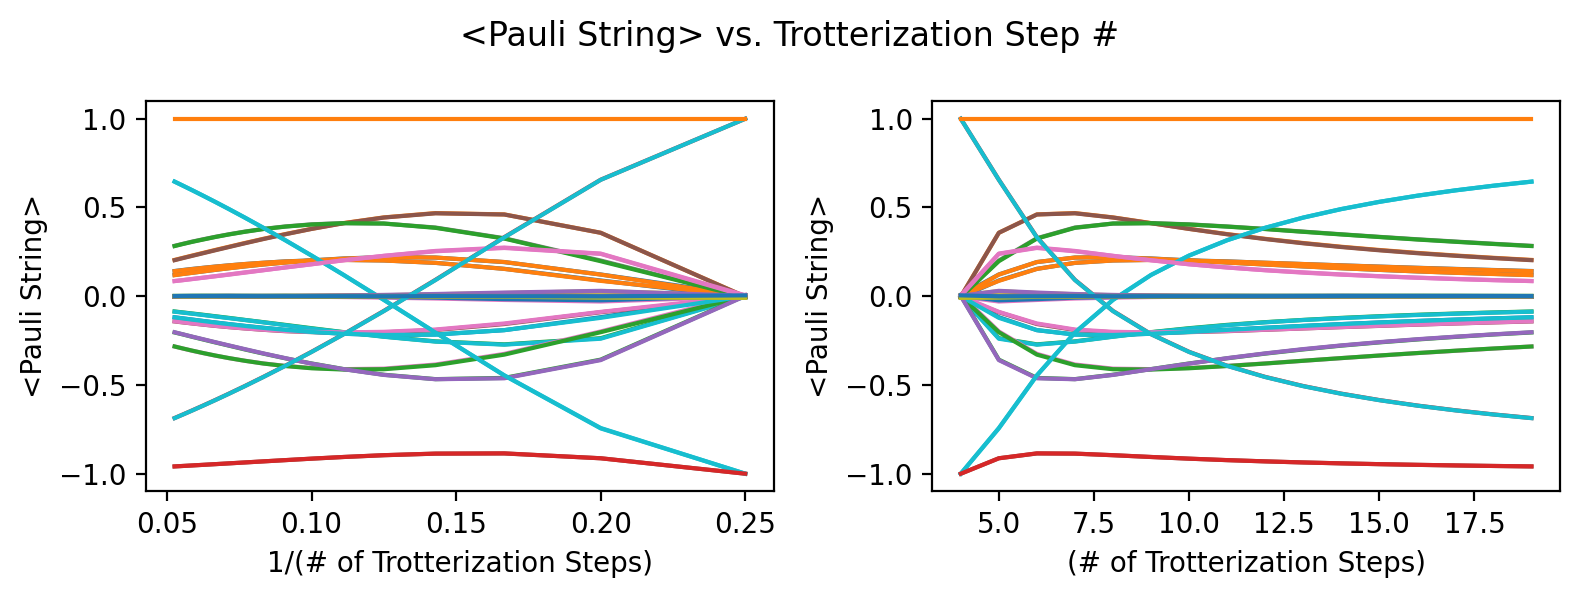

In [121]:
axs = plot_parity(res_analysis)

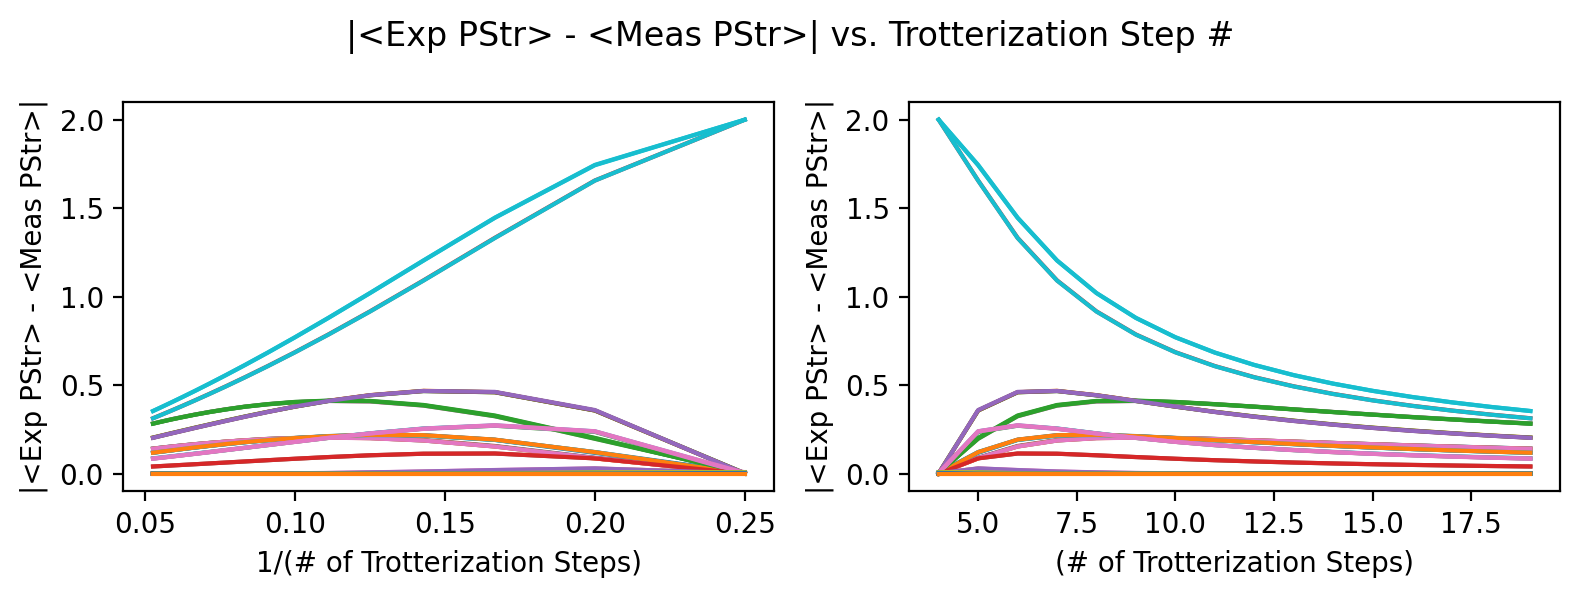

In [122]:
axs = plot_parity_dist(res_analysis)

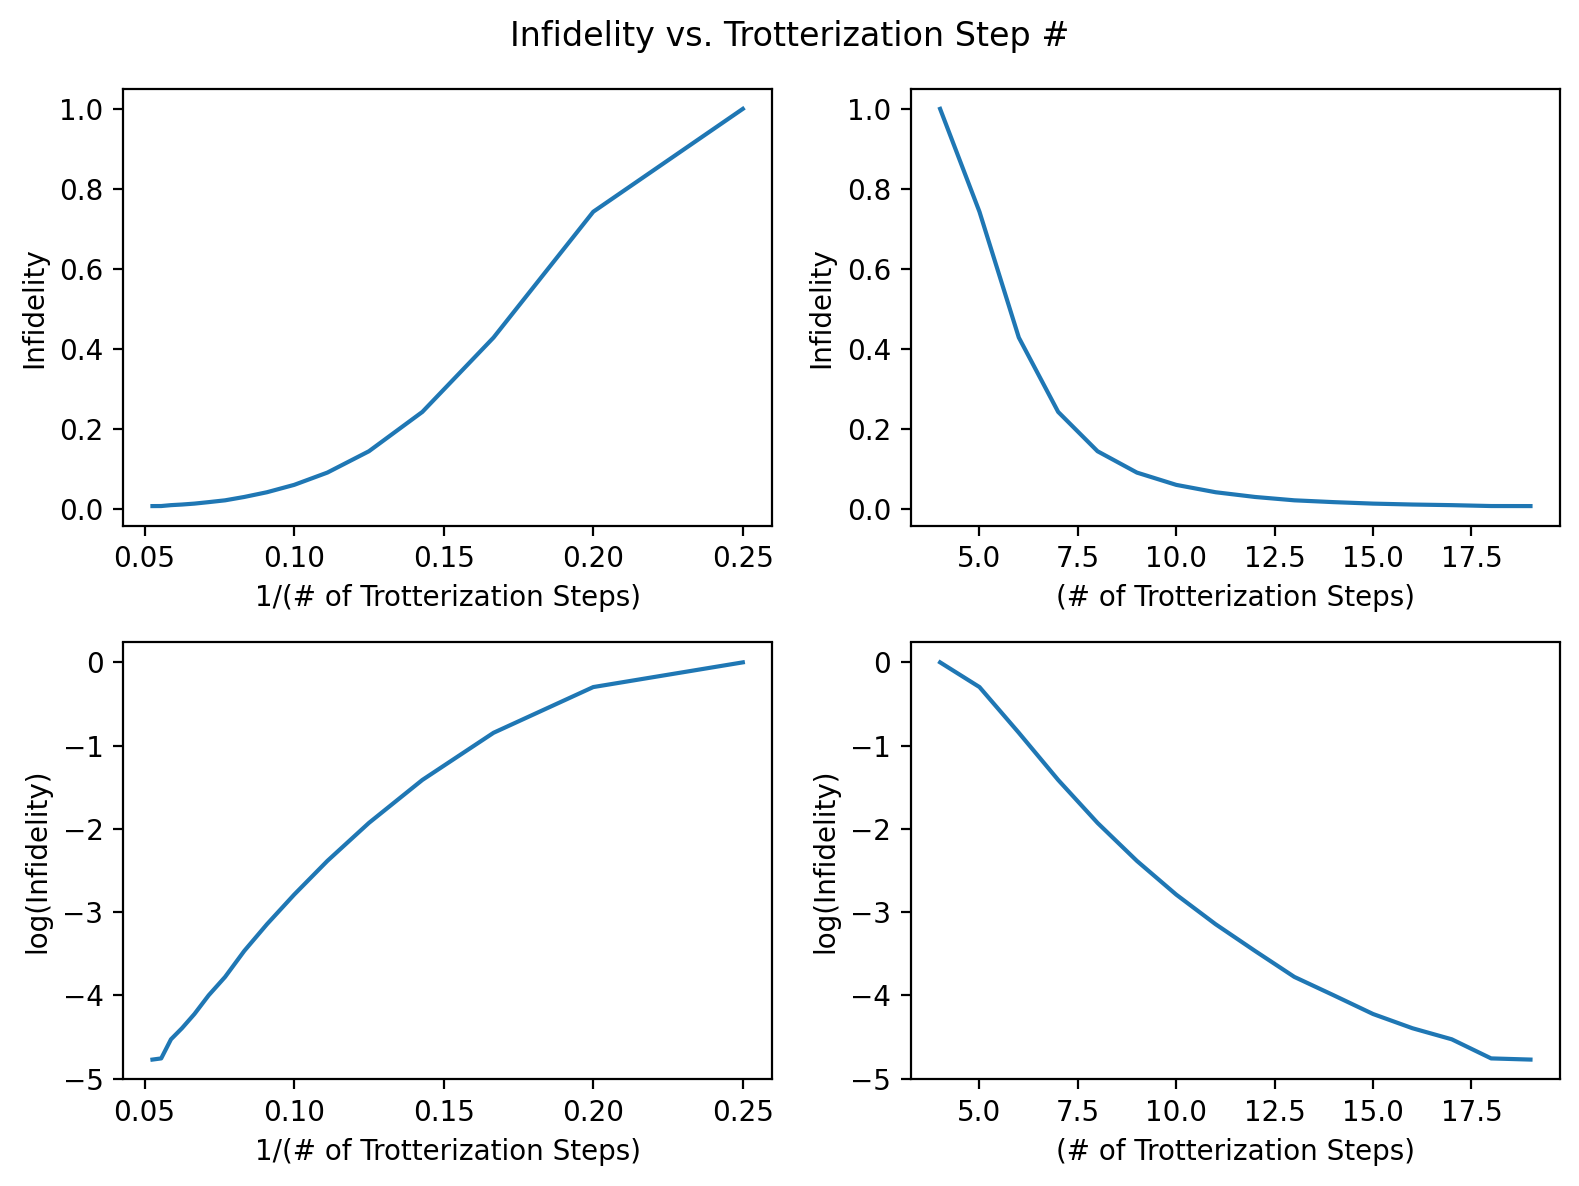

In [94]:
_ = plot_fidelities(res_analysis)

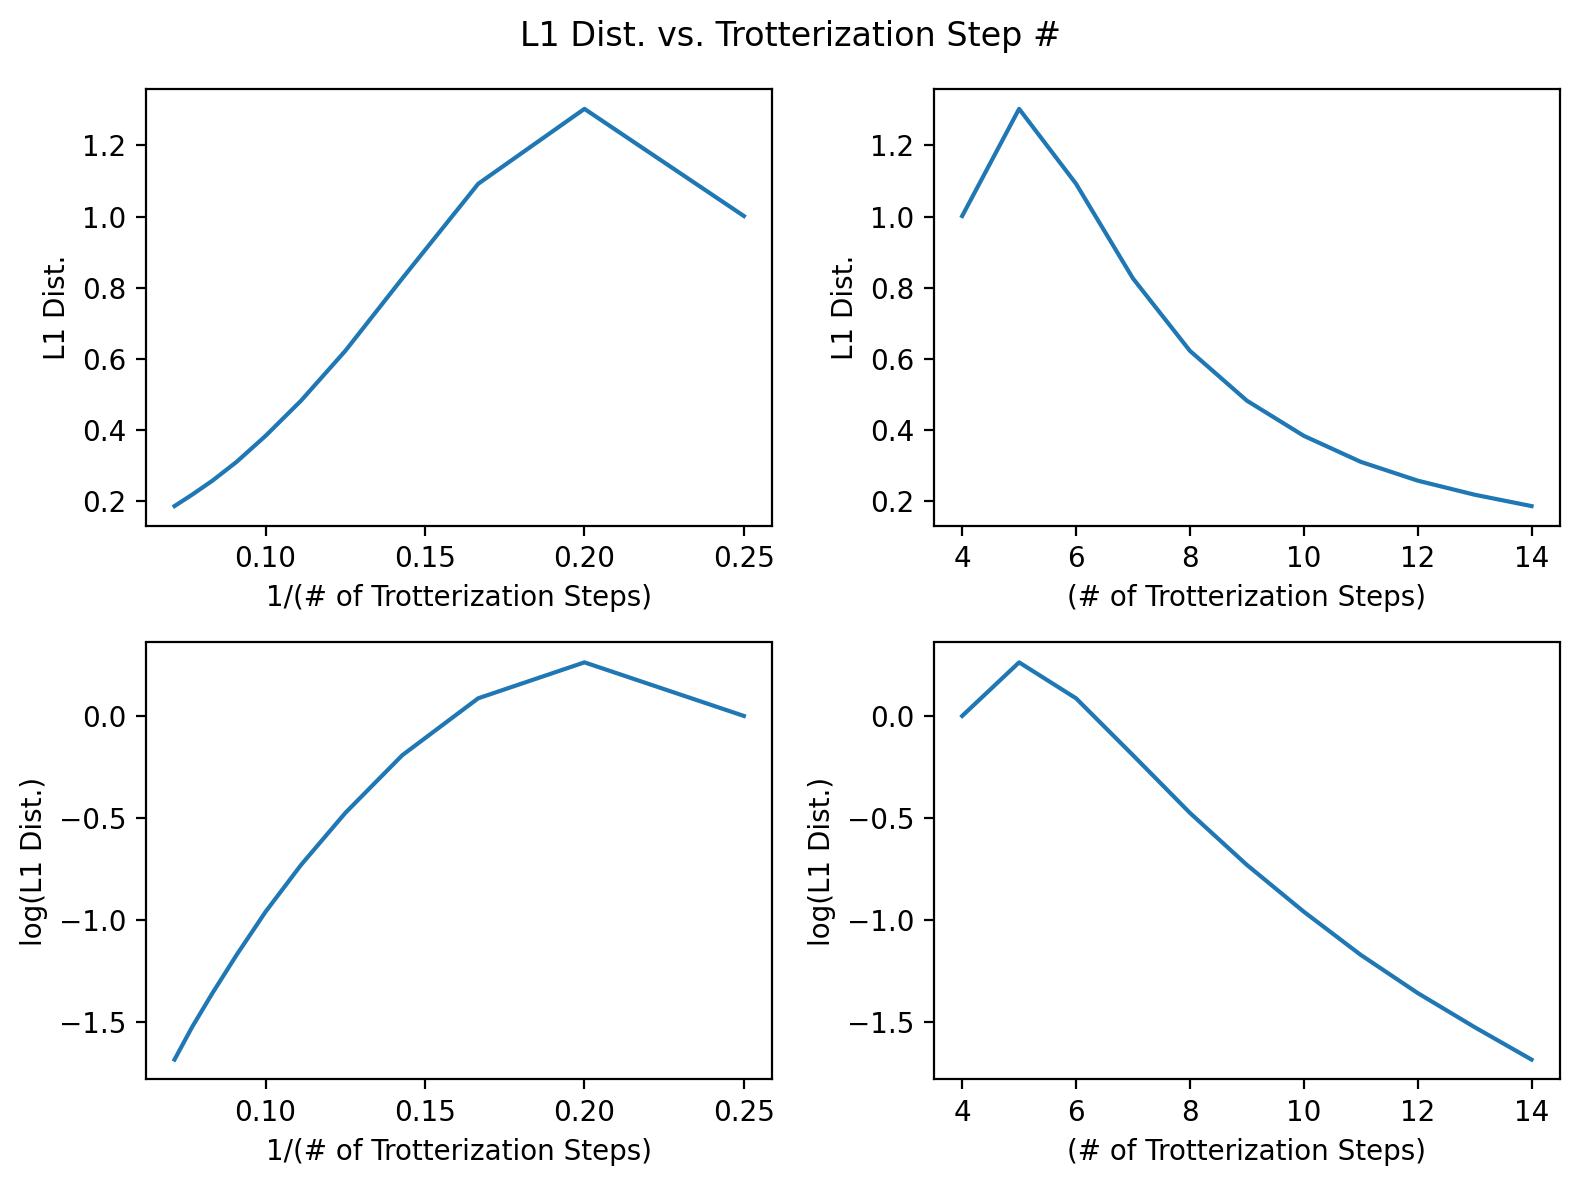

In [200]:
_ = plot_l1_dist(res_analysis)

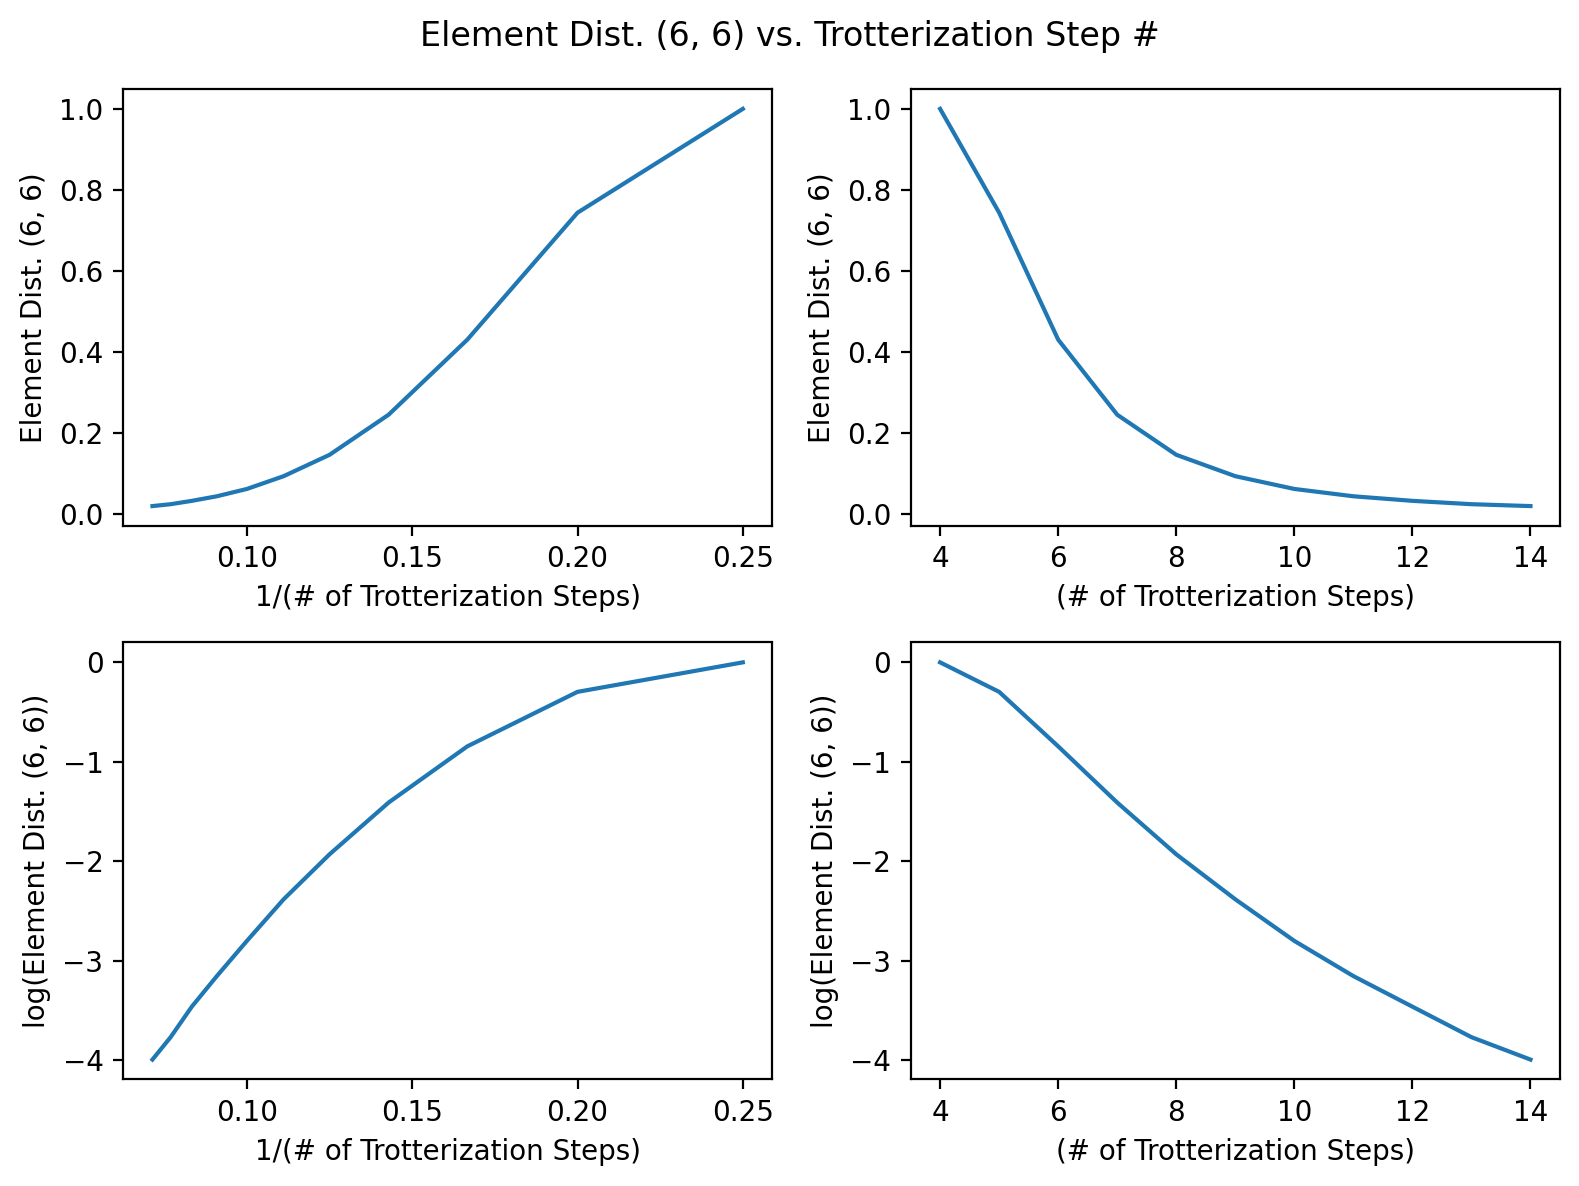

In [211]:
_ = plot_element_dist(res_analysis)

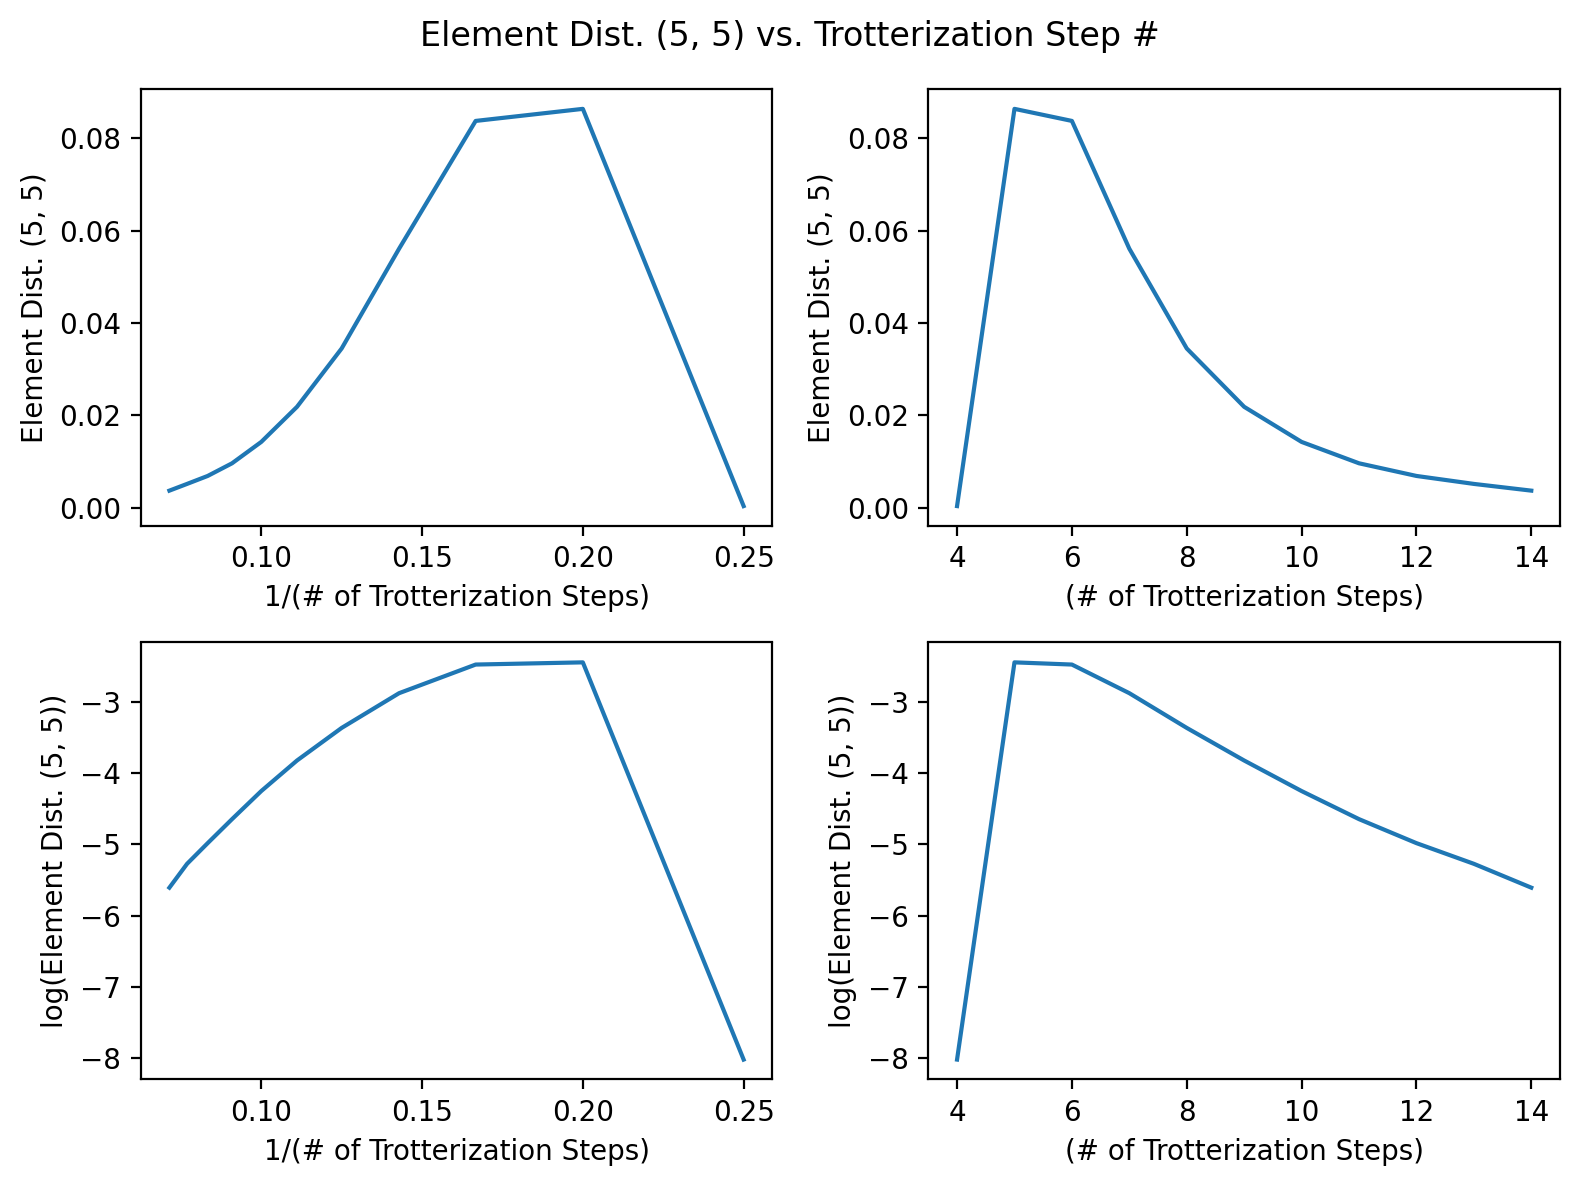

In [212]:
_ = plot_element_dist(res_analysis, row=5, col=5)

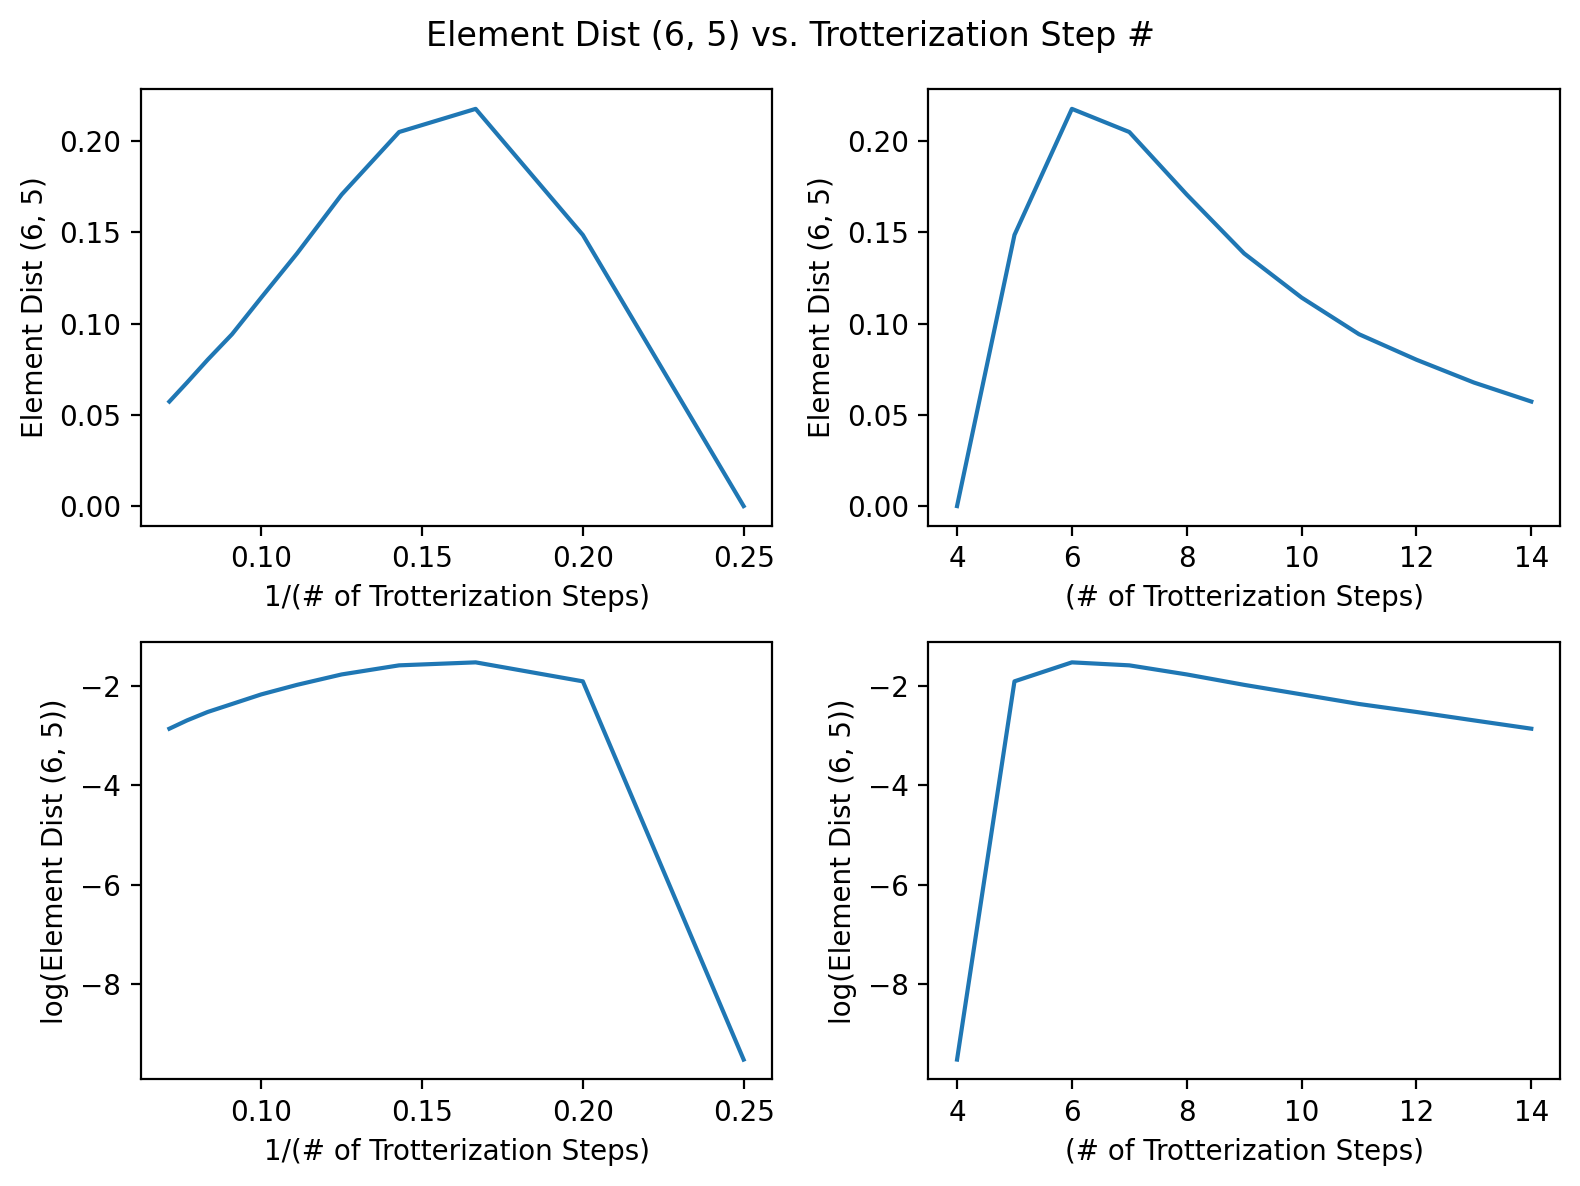

In [152]:
_ = plot_element_dist(res_analysis, row=6, col=5)

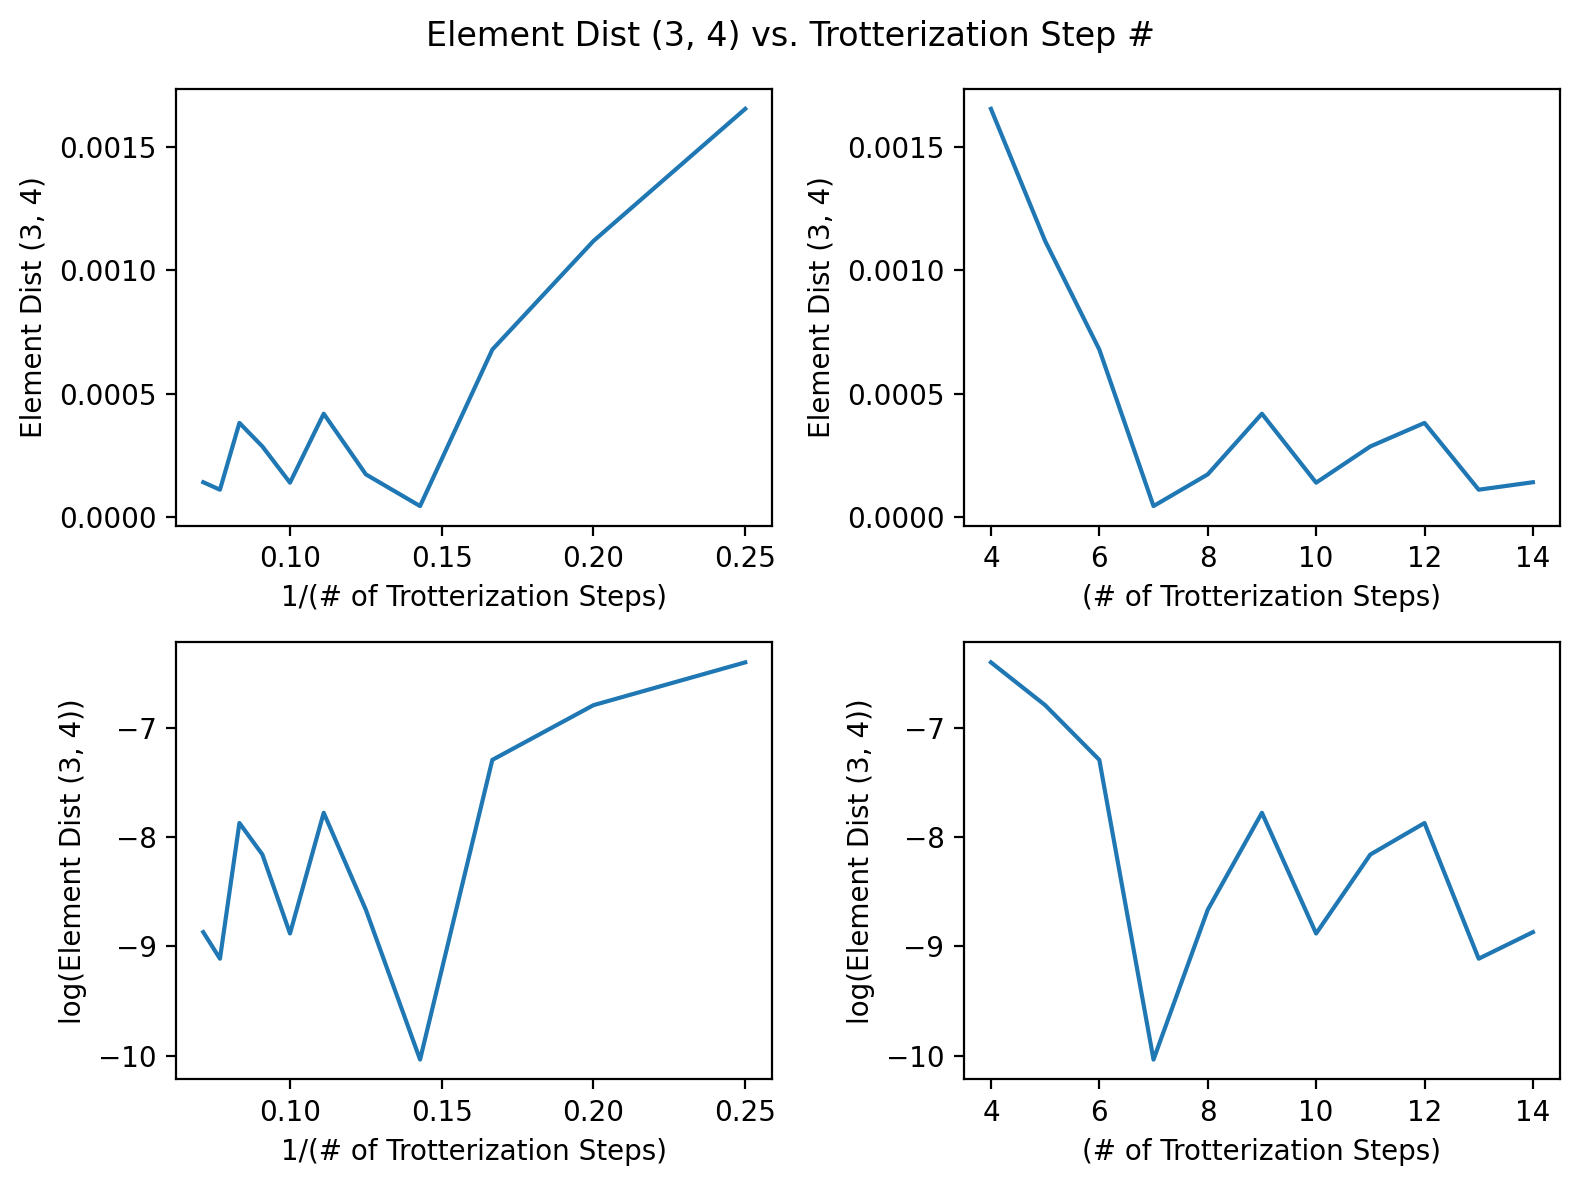

In [149]:
_ = plot_element_dist(res_analysis, row=3, col=4)